In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import random

C:\Users\Rock_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [16]:
def load_photos(directory):
    images = []
    labels_speed = []
    labels_dir = []
    labels_obstacle = []
    dir_list = listdir(directory)
    random.shuffle(dir_list)
    for name in dir_list:
        filename = directory + '/' + name
        # load an image from file
        image = load_img(filename, target_size=(96, 160))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        value_dir = float(name.split('_')[1])
        value_speed = float(name.split('_')[0])
        value_obstacle = [int(name.split('_')[2]), int(name.split('_')[3])]
        labels_dir.append(value_dir)
        labels_speed.append(value_speed)
        labels_obstacle.append(value_obstacle)
        images.append(image)
    return images, labels_speed, labels_dir, labels_obstacle

In [17]:
dataset = "../../../../Pics/BigOne_Race_5_obstacle"

In [23]:
# load images from both train and test groups
directory = dataset+'/Train'
images, labels_speed, labels_dir, labels_obstacle = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)

Loaded Images and labels for training: 8360


In [24]:
#Normalise images
images = np.array(images)
images /= 255.0

In [25]:
#convert datas to dummyvalues
labels_speed = np.array(pd.get_dummies(labels_speed))
labels_dir = np.array(pd.get_dummies(labels_dir))
labels_obstacle = np.array(labels_obstacle)

(array([1, 0], dtype=uint8),
 array([1, 0, 0, 0, 0], dtype=uint8),
 array([0, 0]),
 <matplotlib.image.AxesImage at 0x17a162c94a8>)

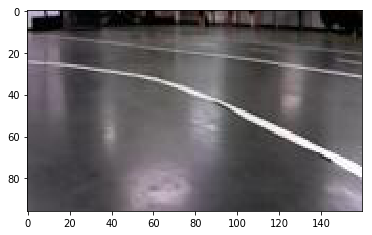

In [26]:
labels_speed[42], labels_dir[42], labels_obstacle[42], plt.imshow(images[42])

In [27]:
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks

In [28]:
#from keras.models import load_model
#model = load_model("model_bigrace_original_5.h5")

In [29]:
'''
Model from PatateV2
'''

K.clear_session()
############################################################# 

img_in = Input(shape=(96, 160, 3), name='img_in')
x = img_in

x = Convolution2D(2, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Convolution2D(4, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Convolution2D(8, (5,5), strides=(2,2), use_bias=False)(x)       
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.5)(x)

x = Flatten(name='flattened')(x)

x = Dense(100, use_bias=False)(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.4)(x)
x = Dense(50, use_bias=False)(x)  
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(.3)(x)

# Multitask Output

out_speed = Dense(2, activation='softmax')(x)

out_dir = Dense(5, activation='softmax')(x)

out_obstacle = Dense(2, activation='sigmoid')(x)


# Compile Model
model = Model(inputs=[img_in], outputs=[out_speed, out_dir, out_obstacle])
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 96, 160, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 78, 2)    150         img_in[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 78, 2)    8           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 78, 2)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [30]:
model_name="model_bigrace_opti_5_obstacle.h5"

In [31]:
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [36]:
h = model.fit(images, [labels_speed, labels_dir, labels_obstacle], batch_size=64, epochs=10, validation_split=0.2, verbose=1, callbacks=[best_checkpoint])

Train on 6688 samples, validate on 1672 samples
Epoch 1/10
6688/6688 [==============================] - 185s 28ms/step - loss: 1.0832 - dense_3_loss: 0.2796 - dense_4_loss: 0.7812 - dense_5_loss: 0.0224 - dense_3_acc: 0.8728 - dense_4_acc: 0.7095 - dense_5_acc: 0.4243 - val_loss: 0.8963 - val_dense_3_loss: 0.2615 - val_dense_4_loss: 0.6124 - val_dense_5_loss: 0.0225 - val_dense_3_acc: 0.8834 - val_dense_4_acc: 0.7799 - val_dense_5_acc: 0.5682

Epoch 00001: val_loss did not improve
Epoch 2/10
6688/6688 [==============================] - 191s 29ms/step - loss: 1.0651 - dense_3_loss: 0.2782 - dense_4_loss: 0.7638 - dense_5_loss: 0.0231 - dense_3_acc: 0.8708 - dense_4_acc: 0.7143 - dense_5_acc: 0.4258 - val_loss: 0.9175 - val_dense_3_loss: 0.2901 - val_dense_4_loss: 0.6055 - val_dense_5_loss: 0.0219 - val_dense_3_acc: 0.8594 - val_dense_4_acc: 0.7673 - val_dense_5_acc: 0.5526

Epoch 00002: val_loss did not improve
Epoch 3/10
6688/6688 [==============================] - 184s 28ms/step - los

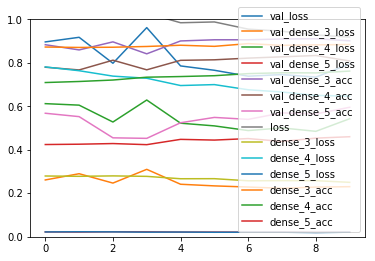

In [37]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))